## Reverse image search and retrieval

This notebook will show you how you can use a convolutional neural network (convnet) to search through a large collection of images. Specifically, it will show you how you can retrieve a set of images which are similar to a query image, returning you its `n` nearest neighbors in terms of image content.

### Installation and dependencies

The code has a number of dependencies, which can usually be installed with `pip`. You will need:

 * [scikit-learn](scikit-learn.org)
 * [keras](https://keras.io)
 * [Pillow](https://python-pillow.org/)
 * [matplotlib](http://matplotlib.org)
 * [cPickle](https://docs.python.org/2/library/pickle.html)

### Prepare dataset

Finally, prepare a folder of images to do the analysis on. If you don't have one, you may download and extract the [Caltech-101 dataset](http://www.vision.caltech.edu/Image_Datasets/Caltech101/) containing roughly 9000 images in 101 categories. To download that dataset, run the following commands inside a folder of your choosing (this notebook will assume you do so in the `data` folder of `ml4a-guides`.

    wget http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
    tar -xvzf 101_ObjectCategories.tar.gz
    
Or you can run the `download.sh` script in the `data` folder which will automatically download this dataset for you, along with all the other materials for these notebooks.

Now we can begin. Run the following import commands and make sure all the libraries are correctly installed and import without errors.

In [110]:
%matplotlib inline
import os
import random
import cPickle as pickle
import numpy as np
import matplotlib.pyplot
from matplotlib.pyplot import imshow
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model
from sklearn.decomposition import PCA
from scipy.spatial import distance
from tqdm import tqdm

We will load a previously-trained neural network, that of VGG16, which comes with Keras. If it's your first time loading it, it will automatically download the weights for you, which will take some time. Afterwards, the weights will be cached locally for future use. Keras has a number of other [pre-trained networs](https://keras.io/applications/) which you can try as well.

Once the network is loaded, we can take a look at the architecture of the network by running `model.summary()`.

In [3]:
model = keras.applications.VGG16(weights='imagenet', include_top=True)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

The summary gives us a layer-by-layer description of the network. Notice that VGG16 is a deep network with 13 convolutional layers. It was previously trained on millions of images, and has over 100,000,000 weights and biases, the majority of which connect to the first fully-connected layer (fc1). 

To see it in action, let's load an image and input it into the network. To help us do this, we will create a function `get_image(path)` which will handle the usual pre-processing steps: load an image from our file system and turn it into an input vector of the correct dimensions, those expected by VGG16, namely a color image of size 224x224.

In [109]:
# get_image will return a handle to the image itself, and a numpy array of its pixels to input the network
def get_image(path):
    img = image.load_img(path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

We load an image into memory, convert it into an input vector, and see the model's top 5 predictions for it.

Predicted kit_fox with probability 21.7
Predicted Egyptian_cat with probability 20.8
Predicted red_fox with probability 13.0
Predicted tabby with probability 12.9
Predicted tiger_cat with probability 9.2


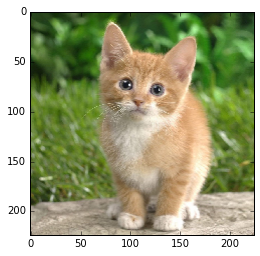

In [15]:
img, x = get_image("../assets/kitty.jpg")
predictions = model.predict(x)
imshow(img)
for pred in decode_predictions(predictions)[0]:
    print("predicted %s with probability %0.3f" % (pred[1], pred[2]))

Now we will remove the top classification layer from our network, leaving the last fully-connected layer, "fc2 (Dense)" as the new output layer. The way we do this is by instantiating a new model called `feature_extractor` which takes a reference to the desired input and output layers in our VGG16 model. Thus, `feature_extractor`'s output is the layer just before the classification, the last 4096-neuron fully connected layer. 

Note about memory: although we instantiate a new object with most of the weights of our large model, it does not actually duplicate all the weights of the previous network into memory. 

If we run the `summary()` function again, we see that the architecture of `feat_extractor` is identical to the original `model`, except the last layer has been removed. We also know that not just the architecture is the same, but the two have the same weights as well.

In [16]:
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
feat_extractor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

Now let's see the feature extractor in action. We pass the same image from before into it, and look at the results. The `predict` function returns an array with one element per image (in our case, there is just one). Each element contains a 4096-element array, which is the activations of the last fully-connected layer in VGG16. Let's plot the array as well.

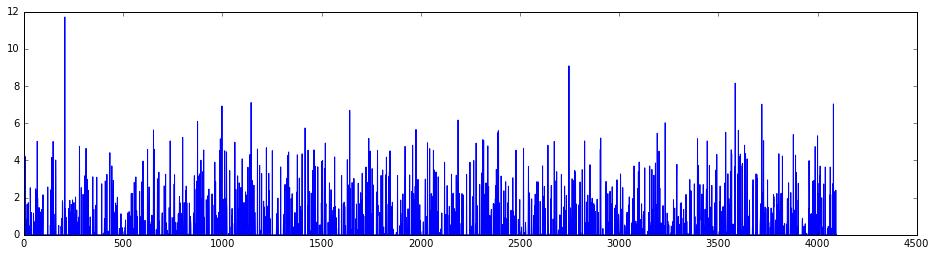

In [18]:
img, x = get_image("../assets/kitty.jpg")
feat = feat_extractor.predict(x)

matplotlib.pyplot.figure(figsize=(16,4))
matplotlib.pyplot.plot(feat[0])
matplotlib.pyplot.show()

Next, we will load all of the images in a directory, and use `feature_extractor` to get a feature vector for each one. If you have your own folder of images you want to analyze, change the path of `images_path` and it will search recursively through all the folders in it. Set `max_num_images` to cap it at some maximum number of images to load (it will grab a random subset of `max_num_images` is less than the number of images in your directory.

If you are using `101_ObjectCategories`, make sure you have followed the instructions above to download it, and make sure the path matches correctly.

In [19]:
images_path = '../data/101_ObjectCategories'
max_num_images = 10000

images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
if max_num_images < len(images):
    images = [images[i] for i in sorted(random.sample(xrange(len(images)), max_num_images))]

print("keeping %d images to analyze" % len(images))

keeping 9144 images to analyze


The next part will take the longest. We iterate through and extract the features from all the images in our `images` array, placing them into an array called `features`. 

In [20]:
features = []
for image_path in tqdm(images):
    img, x = get_image(image_path);
    feat = feat_extractor.predict(x)[0]
    features.append(feat)


100%|██████████| 9144/9144 [2:13:59<00:00,  1.66it/s]


Once that is done, we will take our `n`x4096 matrix of features (where `n` is the number of images), and apply [principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) to it, and keep the first 300 principal components, creating an `n`x300 matrix called `pca_features`. 

The purpose of principal component analysis is to reduce the dimensionality of our feature vectors. This reduces the amount of redundancy in our features (from duplicate or highly-correlated features), speeds up computation over them, and reduces the amount of memory they take up. 



Let's do a query. What we'll do is define a function which returns the num_results closest images to a query image, with repsect to those images contents. What it dos is: for the given query image, it will take its PCA-activations, and compute the euclidean distance between it and every other set of PCA-activations, then return the best ones.
We also define a helper function get_concatenated_images which creates a thumbnail of a set of images, so we can display the results.

In [21]:
features = np.array(features)
pca = PCA(n_components=300)
pca.fit(features)
pca_features = pca.transform(features)

We are now ready to do our reverse image queries! The matrix `pca_features` contains a compact representation of our images, one 300-element row for each image with high-level feature detections. We should expect that two similar images, which have similar content in them, should have similar arrays in `pca_features`.

Thus we can define a new function `get_closest_images`, which will compute the euclidean distance between the PCA features of `query_image_idx`-th image in our dataset, and the PCA features of every image in the dataset (including itself, trivially 0). It then returns an array of indices to the `num_results` (default is 5) most similar images to it (not including itself). 

We also define a helper function `get_concatenated_images` which will simply take those resulting images and concatenate them into a single image for easy display.

In [44]:
def get_closest_images(query_image_idx, num_results=5):
    distances = [ distance.euclidean(pca_features[query_image_idx], feat) for feat in pca_features ]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:num_results+1]
    return idx_closest

def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        img = image.load_img(images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image


Finally we can do a query on a randomly selected image in our dataset.

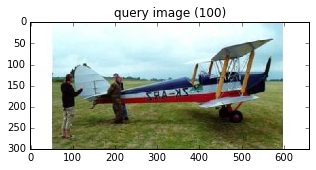

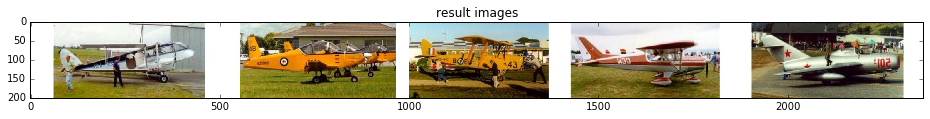

In [45]:
# do a query on a random image
query_image_idx = int(len(images) * random.random())
idx_closest = get_closest_images(query_image_idx)
query_image = get_concatenated_images([query_image_idx], 300)
results_image = get_concatenated_images(idx_closest, 200)

# display the query image
matplotlib.pyplot.figure(figsize = (5,5))
imshow(query_image)
matplotlib.pyplot.title("query image (%d)" % query_image_idx)

# display the resulting images
matplotlib.pyplot.figure(figsize = (16,12))
imshow(results_image)
matplotlib.pyplot.title("result images")

If we are satisfied with the quality of our image vectors, now would be a good time to save them to disk for later usage. You will need these vectors to run the [next notebook on making an image t-SNE](image-tsne.ipynb).

We need to save both the image features matrix (the PCA-reduced features, not the originals), as well as the array containing the paths to each image, to make sure we can line up the images to their corresponding vectors. 

In [46]:
pickle.dump([images, pca_features], open('../data/features_caltech101.p', 'wb'))

Another thing you can try is to do is fine a path between two images containing `n` images. The below is a naive approach to this problem which finds the closest image to the `n` vectors which are interpolated between those of the endpoint images. A better one would be to use a variant of [Dijkstra's algorithm](https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm) (implementation TBD). This implementation is not particularly good; improvement TBD (suggestions are welcome!)

With the naive approach, we run another principal component analysis, this time reducing down all the way to 3 dimensions. The reason for this is when there are too many dimensions and the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality) sets in, most images cluster strongly around their class, and there are few images between classes.  In a low-dimensional space, this isn't as much a problem. So we first run a new PCA, saving the columns to `pca_features2`.

In [89]:
features = np.array(features)
pca2 = PCA(n_components=3)
pca2.fit(features)
pca_features2 = pca2.transform(features)

Then we define our function `get_image_path_between` which will make `num_hops` sized stops between two images, and grab the closest image at each step, then concatenate them together and display them.

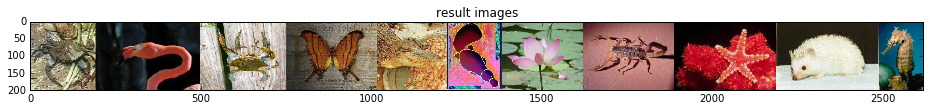

In [108]:
def get_image_path_between(query_image_idx_1, query_image_idx_2, num_hops=4):
    path = [query_image_idx_1, query_image_idx_2]
    for hop in range(num_hops-1):
        t = float(hop+1) / num_hops
        lerp_acts = t * pca_features2[query_image_idx_1] + (1.0-t) * pca_features2[query_image_idx_2]
        distances = [distance.euclidean(lerp_acts, feat) for feat in pca_features2]
        idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])
        path.insert(1, [i for i in idx_closest if i not in path][0])
    return path

# pick image and number of hops
num_hops = 10
query_image_idx_1 = int(len(images) * random.random())
query_image_idx_2 = int(len(images) * random.random())

# get path
path = get_image_path_between(query_image_idx_1, query_image_idx_2, num_hops)

# draw image
path_image = get_concatenated_images(path, 200)
matplotlib.pyplot.figure(figsize = (16,12))
imshow(path_image)
matplotlib.pyplot.title("result images")